In [ ]:
import jax
import time
import random
import string
import datetime
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Callable, Any, Tuple
from functools import partial

## **Single Chip Performance Exploration**

This notebook explores the performance characteristics of a single chip using JAX. We will perform basic operations like matrix addition and matrix multiplication, time these operations, and then introduce the concept of the Roofline model to understand performance limitations. Finally, we will conduct experiments to visualize an experimental roofline.

First, we define a utility function `timing_fn` to measure the execution time of JAX functions. This function will handle warm-up runs and optional JAX tracing for detailed performance analysis.


In [ ]:
def timing_fn(f: Callable, *args: Any, tries: int = 10, task: str | None = None, trace: bool = False) -> Tuple[float, str | None]:
    '''Times a function for multiple runs, with optional JAX tracing.

    Args:
        f: The function to time.  Must be a callable.
        *args: Positional arguments to pass to the function.
        tries: The number of times to run the function.
        task: A descriptive string for the task being timed (used for trace file naming).
            Required if `trace` is True, otherwise can be None.
        trace: If True, enable JAX tracing. Defaults to False.

    Returns:
        A tuple: (average_time_ms, trace_dir).  trace_dir will be None if trace is False.

    Raises:
        TypeError: if task is None and trace is True.
    '''

    outcomes_ms = []
    jax.block_until_ready(f(*args))  # Warm-up run: important for JIT compilation and cache effects.

    trace_dir = None
    if trace:
        if task is None:
            raise TypeError("The 'task' argument cannot be None when 'trace' is True.")
        trace_name = f"t_{task}_" + ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
        trace_dir = f"/tmp/{trace_name}"
        jax.profiler.start_trace(trace_dir) # Start tracing to capture detailed performance information

    for _ in range(tries):
        start_time = time.perf_counter()
        jax.block_until_ready(f(*args)) # Execute the function and wait for JAX to finish
        end_time = time.perf_counter()
        outcomes_ms.append((end_time - start_time) * 1000) # Convert time to milliseconds

    if trace:
        jax.profiler.stop_trace() # Stop tracing after timing loop

    average_time_ms = sum(outcomes_ms) / len(outcomes_ms) # Calculate average time
    return average_time_ms, trace_dir

In [ ]:
def init_matrices(a_x=18500, a_y=18500, b_x=18500, b_y=18500, dtype='float32'):
  A = jax.numpy.ones((a_x, a_y), dtype=dtype)
  B = jax.numpy.ones((b_x, b_y), dtype=dtype)
  return A, B

### **Experiment 1: Element-wise Matrix Addition (A+B)**

In this experiment, we measure the time taken to perform element-wise addition of two large matrices. This operation is typically memory-bandwidth bound, meaning its performance is primarily limited by how fast data can be moved to and from memory, rather than by the computational speed of the processor.

We initialize two square matrices `A` and `B` of size `X_DIM` x `Y_DIM` with ones.

In [ ]:
# @title Element-wise matrix addition
x_dim = 18500 # @param {"type":"integer"}
y_dim = 18500 # @param {"type":"integer"}
dtype = 'bfloat16'
steps = 100 # @param {"type":"integer"}

def f_add_2(A, B):
  return jnp.add(A, B).astype(dtype)# Element-wise addition function

A, B = init_matrices(x_dim, y_dim, x_dim, y_dim, dtype)
average_time, _ = timing_fn(f_add_2, A, B, tries=steps) # Time the matrix addition operation

print(f'Operation-> A:({x_dim}x{y_dim}) + B:({x_dim}x{y_dim})')
print(f'Average time to add two matrices in m seconds: {average_time/1000}')

Operation-> A:(18500x18500) + B:(18500x18500)
Average time to add two matrices in m seconds: 0.009330100499973924


Now, let's calculate the performance metrics for this operation:

*   **Bytes moved**: To perform A+B and store the result (implicitly, although we don't explicitly store it in this timing example for simplicity), we need to read matrix A, read matrix B, and potentially write the result (though in this timing example, we only wait for computation completion, not explicit storage). Assuming we are using single-precision floating-point numbers (FP32, 4 bytes per element), the total bytes moved is approximately 3 times the size of one matrix (reading A, reading B, and writing the result, although the write is not explicitly timed here, we consider the data movement involved in the operation).
*   **FLOPs (Floating Point Operations)**: Element-wise addition is considered to have approximately one FLOP per element. For matrices of size `X_DIM` x `Y_DIM`, this is `X_DIM` * `Y_DIM` FLOPs.
*   **Achieved TeraFLOPs per second (TFPS)** and **GigaBytes per second (GB/s)**:  We can calculate these from the measured time, bytes moved, and FLOPs.

In [ ]:
# @title Performance Metrics for Element-Wise Addition
x_dim = 18500 # @param {"type":"integer"}
y_dim = 18500 # @param {"type":"integer"}
dtype = 'bfloat16'
steps = 100 # @param {"type":"integer"}

A, B = init_matrices(x_dim, y_dim, x_dim, y_dim, dtype)

bytes_per_matrix = A.size * jnp.dtype(dtype).itemsize # Multiply the size  of the array with the type size
total_bytes = 3 * bytes_per_matrix # Reading A, B and "writing" (in operation) the result (approximation)

total_flops = x_dim * y_dim # Element-wise addition: one FLOP per element

average_time, _ = timing_fn(f_add_2, A, B, tries=steps) # Time the matrix addition operation

t_flops_per_sec = (total_flops/average_time)/1e9 # TeraFLOPs per second
gbytes_per_sec = (total_bytes/average_time)/1e6 # GigaBytes per second

print(f'Average Time in seconds: {average_time/1000}')
print(f'Total Flops: {total_flops}')
print(f'Total Bytes: {total_bytes}')
print(f'Achieved TFlops/sec: {t_flops_per_sec:.8f}')
print(f'Achieved GB/sec: {gbytes_per_sec:.2f}')

del A # Clean up memory
del B # Clean up memory

Average Time in seconds: 0.00926874212000257
Total Flops: 342250000
Total Bytes: 2053500000
Achieved TFlops/sec: 0.03692518
Achieved GB/sec: 221.55


### **Experiment 2: Matrix Multiplication (C = A @ B)**
Next, we measure the performance of matrix multiplication. Matrix multiplication is generally more compute-intensive than element-wise addition and can be either memory-bound or compute-bound depending on the matrix size and the architecture's characteristics.

In [ ]:
# @title Performance Metrics for Element-Wise Addition
x_dim = 18500 # @param {"type":"integer"}
z_dim = 18500 # @param {"type":"integer"}
y_dim = 10000 # @param {"type":"integer"}
dtype = 'float32'
steps = 50 # @param {"type":"integer"}


def f_mul(A, B):
  return jnp.matmul(A, B) # Matrix multiplication function

A, B = init_matrices(x_dim, z_dim, z_dim, y_dim, dtype)
average_time, _ = timing_fn(f_mul, A, B, tries=steps) # Time matrix multiplication

print(f' average time in seconds: {average_time/1000}')
del A # Clean up memory
del B # Clean up memory

 average time in seconds: 0.3085709788600161


## **Introduction to the Roofline Model**

The Roofline model is a visual performance analysis tool that helps to understand the performance limitations of a computation on a given hardware architecture. It plots the achievable performance (typically in FLOPs per second) as a function of Arithmetic Intensity (AI).

#### **Key Concepts:**

**Arithmetic Intensity (AI):** Defined as the ratio of operations (FLOPs) to bytes moved to/from memory (Bytes). AI = FLOPs / Bytes. It quantifies the amount of computation performed per byte of data accessed. Operations with high AI are compute-bound, while operations with low AI are memory-bound.

**Roofline Plot:** A graph with Arithmetic Intensity on the x-axis and Performance (FLOPs/sec) on the y-axis. It typically has two "roofs":

**Compute Roof:** Represents the peak computational throughput of the processor. This is a horizontal line indicating the maximum FLOPs/sec the processor can achieve.

**Memory Bandwidth Roof:** Represents the peak memory bandwidth. This is a diagonal line because performance is limited by memory bandwidth at lower arithmetic intensities. The slope of this line is determined by the peak memory bandwidth.

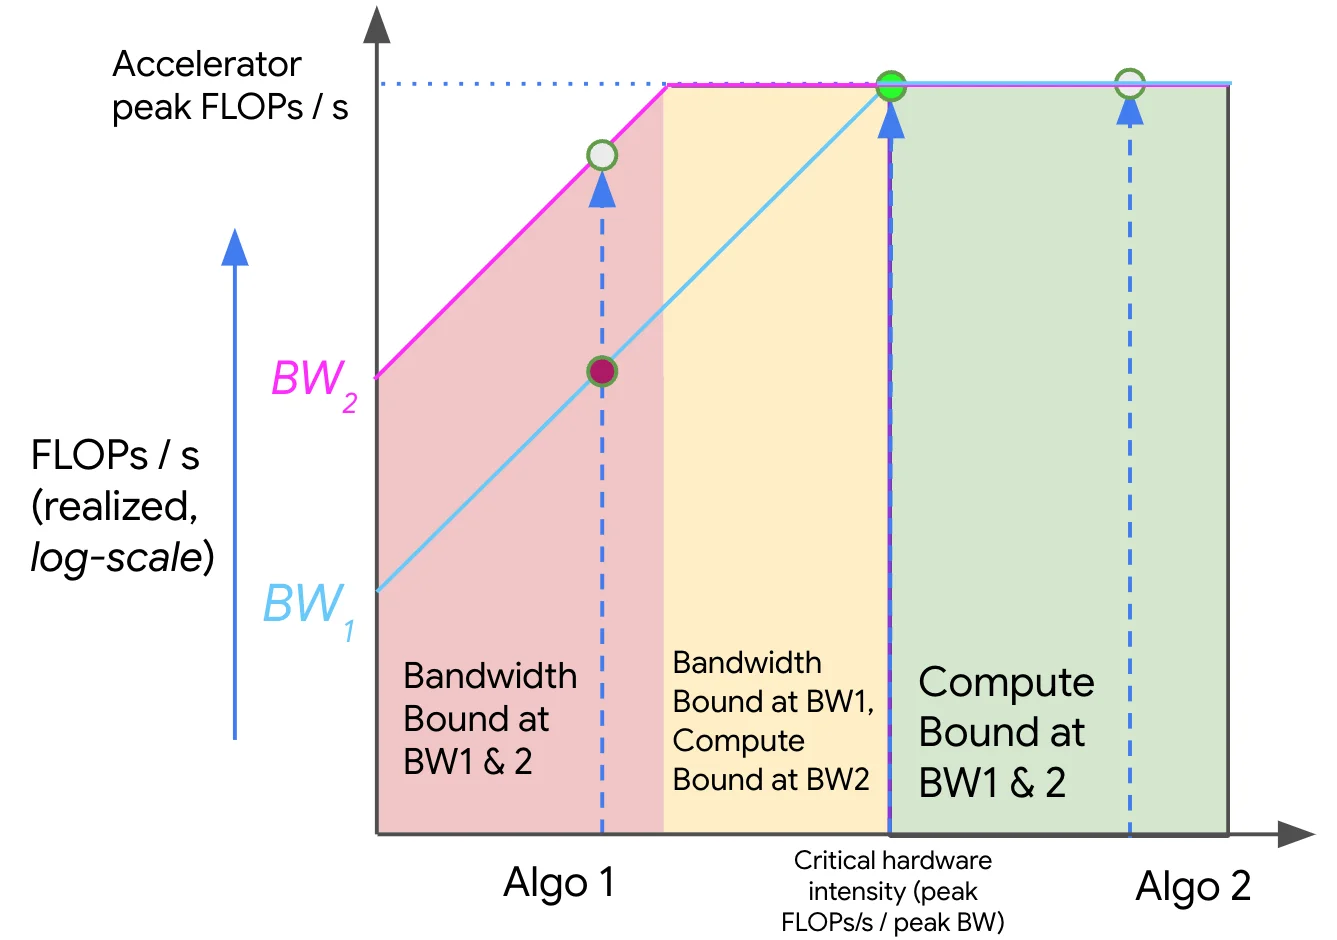


### **Interpreting the Roofline:**

For operations with low arithmetic intensity, performance is limited by the memory bandwidth roof. Increasing computational power will not improve performance significantly unless memory bandwidth is also increased. These operations are memory-bound.

For operations with high arithmetic intensity, performance is limited by the compute roof. These operations are compute-bound.

Mathematical Derivation of Arithmetic Intensity for Matrix Multiplication (C = A @ B)

Let's consider matrix multiplication C = A @ B, where A is an (M x K) matrix, B is an (K x N) matrix, and C is the resulting (M x N) matrix.


**1. Floating Point Operations (FLOPs):**
For each element in the resulting matrix C, we perform approximately 2K floating-point operations (K multiplications and K-1 additions). Since there are M x N elements in C, the total number of FLOPs is approximately:


```
FLOPs ≈ 2 * M * K * N
```



**2. Bytes Moved (Data Access):**
To compute C = A @ B, we need to:

Load matrix A from memory.

Load matrix B from memory.

Store the resulting matrix C back to memory.

Assuming each element is represented by 2 bytes (BF16), the total bytes moved are:


```
Bytes ≈ Size(A) + Size(B) + Size(C) = (M * K * 2) + (K * N * 2) + (M * N * 2) = 2 * (M * K + K * N + M * N)
```
Note: In some analyses, especially when considering cache effects and reuse, the bytes moved might be estimated differently, focusing on the minimum data movement from main memory. However, for a simple first-order roofline analysis, considering all data loaded and stored is a reasonable starting point.


**3. Arithmetic Intensity (AI)**:
Arithmetic Intensity is the ratio of FLOPs to Bytes moved:


```
AI = FLOPs / Bytes ≈ 2 * M * K * N / 2 * (M * K + K * N + M * N)
```
Assuming the first f we assume our local “batch size” M is small relative to K and N:
```
M * K * N / (M * K + K * N + M * N) = M * K * N / K * N = M
≈ O(M).
```
Therefore, for matrix multiplication, the arithmetic intensity is approximately proportional to M. This means as the matrix size M increases, the arithmetic intensity also increases. Larger matrix multiplications become more compute-bound.


### **Experiment 3: Varying Workload Size and Observing Roofline Behavior**

In this experiment, we vary the size of the matrix multiplication workload and observe how the performance and arithmetic intensity change. We expect to see that as matrix size increases (and thus arithmetic intensity increases), we might move from being memory-bound to potentially being closer to compute-bound, up to the limits of the hardware.

We will iterate through different matrix sizes, perform batched matrix multiplications to keep the total workload significant and nearly equal, and measure the achieved performance and arithmetic intensity for each size. We will then plot these points on a scatter plot to visualize an experimental "roofline".

We use bfloat16 datatype here to potentially leverage hardware acceleration for lower precision computation, which is common in modern accelerators.

In [ ]:
times = []
total_bytes = []
total_flops = []
ais = []
tera_flops_per_sec = []
giga_bytes_per_sec = []

@jax.jit  # JIT compile for performance
def f(X,Y):
    return jax.lax.batch_matmul(X,Y)  # Batched matrix multiplication

# Define multiple dimensions for testing
# For each tuple (m, k, n), we'll create matrices with shapes:
# A: (batch, m, k) and B: (batch, k, n)
dimensions = []
for i in range(7, 15):
    base_size = 2**i
    # Create different matrix dimension combinations
    m = base_size
    k = base_size // 2  # Half the base size for middle dimension
    n = base_size * 2   # Double the base size for output dimension
    dimensions.append((m, k, n))

for m, k, n in dimensions:
    # Ensure at least 1 batch, but scale down as matrix sizes grow
    num_matmuls = max(1, 2**29 // (m * k + k * n + m * n))

    A = jax.numpy.ones ((num_matmuls, m, k), dtype=jax.numpy.bfloat16) # bfloat16 for potential hardware acceleration
    B = jax.numpy.ones ((num_matmuls, k, n), dtype=jax.numpy.bfloat16)

    num_bytes_A = A.size * 2  # Bytes for A input matrix (bfloat16 is 2 bytes)
    num_bytes_B = B.size * 2  # Bytes for B input matrix (bfloat16 is 2 bytes)
    num_bytes_output = num_matmuls * m * n * 2  # Output matrix size (bfloat16 is 2 bytes)
    bytes_to_hbm = num_bytes_A + num_bytes_B + num_bytes_output # Estimate total bytes moved (inputs and output) - for roofline AI

    # Calculate FLOPs: each output element requires 2*k operations
    flops = 2 * k * m * n * num_matmuls

    # Time the operation
    average_time, _ = timing_fn(f, A, B, task=f'matmul_{m}x{k}x{n}')
    del A; del B  # Memory cleanup

    arithmetic_intensity = flops / bytes_to_hbm  # Calculate Arithmetic Intensity (FLOPs per Byte)
    tfps = flops / average_time / 1e9  # Calculate TeraFLOPs per second
    gbps = bytes_to_hbm / average_time / 1e6  # Calculate TeraBytes per second

    print(f'Dimensions: A({m}x{k}), B({k}x{n}), TFPS: {tfps:.2f}, GBPS: {gbps:.2f}, AI: {arithmetic_intensity:.2f}')

    ais.append(arithmetic_intensity)
    tera_flops_per_sec.append(tfps)
    giga_bytes_per_sec.append(gbps)

    times.append(average_time)
    total_bytes.append(bytes_to_hbm)
    total_flops.append(flops)


Dimensions: A(128x64), B(64x256), TFPS: 7.65, GBPS: 209.18, AI: 36.57
Dimensions: A(256x128), B(128x512), TFPS: 14.83, GBPS: 202.71, AI: 73.14
Dimensions: A(512x256), B(256x1024), TFPS: 20.31, GBPS: 138.84, AI: 146.29
Dimensions: A(1024x512), B(512x2048), TFPS: 21.24, GBPS: 72.58, AI: 292.57
Dimensions: A(2048x1024), B(1024x4096), TFPS: 21.86, GBPS: 37.35, AI: 585.14
Dimensions: A(4096x2048), B(2048x8192), TFPS: 22.17, GBPS: 18.94, AI: 1170.29
Dimensions: A(8192x4096), B(4096x16384), TFPS: 22.13, GBPS: 9.45, AI: 2340.57
Dimensions: A(16384x8192), B(8192x32768), TFPS: 22.61, GBPS: 4.83, AI: 4681.14


### **Experiment 4: Varying M dimension and Observing Roofline Behavior**

As in the pervisou experiment, we are going to vary the matrix dimension but this time we are going to just vary the M dimension as it has the most signficant effect on the arthimitic intensity.

In [ ]:
times = []
total_bytes = []
total_flops = []
ais = []
tera_flops_per_sec = []
giga_bytes_per_sec = []

@jax.jit  # JIT compile for performance
def f(X,Y):
    return jax.lax.batch_matmul(X,Y)  # Batched matrix multiplication

# Keep k and n constant, vary m
k = 8000  # Fixed inner dimension
n = 8000  # Fixed output width
dimensions = []
for i in range(2, 16):
    # Vary m while keeping k and n constant
    m = 2**i
    dimensions.append((m, k, n))

for m, k, n in dimensions:
    A = jax.numpy.ones((m, k), dtype=jax.numpy.bfloat16) # bfloat16 for potential hardware acceleration
    B = jax.numpy.ones((k, n), dtype=jax.numpy.bfloat16)

    num_bytes_A = A.size * 2  # Bytes for A input matrix (bfloat16 is 2 bytes)
    num_bytes_B = B.size * 2  # Bytes for B input matrix (bfloat16 is 2 bytes)
    num_bytes_output = m * n * 2  # Output matrix size (bfloat16 is 2 bytes)
    bytes_to_hbm = num_bytes_A + num_bytes_B + num_bytes_output # Estimate total bytes moved (inputs and output) - for roofline AI

    # Calculate FLOPs: each output element requires 2*k operations
    flops = 2 * k * m * n

    # Time the operation
    average_time, _ = timing_fn(f, A, B, task=f'matmul_{m}x{k}x{n}')
    del A; del B  # Memory cleanup

    arithmetic_intensity = flops / bytes_to_hbm  # Calculate Arithmetic Intensity (FLOPs per Byte)
    tfps = flops / average_time / 1e9  # Calculate TeraFLOPs per second
    gbps = bytes_to_hbm / average_time / 1e6  # Calculate GigaBytes per second

    print(f'Dimensions: A({m}x{k}), B({k}x{n}), TFPS: {tfps:.2f}, GBPS: {gbps:.2f}, AI: {arithmetic_intensity:.2f}')

    ais.append(arithmetic_intensity)
    tera_flops_per_sec.append(tfps)
    giga_bytes_per_sec.append(gbps)

    times.append(average_time)
    total_bytes.append(bytes_to_hbm)
    total_flops.append(flops)

Dimensions: A(4x8000), B(8000x8000), TFPS: 0.37, GBPS: 93.15, AI: 4.00
Dimensions: A(8x8000), B(8000x8000), TFPS: 0.69, GBPS: 86.19, AI: 7.98
Dimensions: A(16x8000), B(8000x8000), TFPS: 1.39, GBPS: 87.40, AI: 15.94
Dimensions: A(32x8000), B(8000x8000), TFPS: 2.72, GBPS: 85.70, AI: 31.75
Dimensions: A(64x8000), B(8000x8000), TFPS: 5.67, GBPS: 90.03, AI: 62.99
Dimensions: A(128x8000), B(8000x8000), TFPS: 11.44, GBPS: 92.22, AI: 124.03
Dimensions: A(256x8000), B(8000x8000), TFPS: 14.79, GBPS: 61.46, AI: 240.60
Dimensions: A(512x8000), B(8000x8000), TFPS: 17.53, GBPS: 38.61, AI: 453.90
Dimensions: A(1024x8000), B(8000x8000), TFPS: 20.04, GBPS: 24.58, AI: 815.29
Dimensions: A(2048x8000), B(8000x8000), TFPS: 20.86, GBPS: 15.40, AI: 1354.50
Dimensions: A(4096x8000), B(8000x8000), TFPS: 21.46, GBPS: 10.60, AI: 2023.72
Dimensions: A(8192x8000), B(8000x8000), TFPS: 21.85, GBPS: 8.13, AI: 2687.66
Dimensions: A(16384x8000), B(8000x8000), TFPS: 22.03, GBPS: 6.85, AI: 3215.07
Dimensions: A(32768x800

#### **Plotting the Experimental Roofline**
Finally, we plot the achieved TeraFLOPs per second against the Arithmetic Intensity for each matrix size. This scatter plot represents our experimental roofline. We expect to see a trend where performance increases with arithmetic intensity, potentially plateauing at some point, reflecting the memory bandwidth and compute capabilities of the underlying hardware.

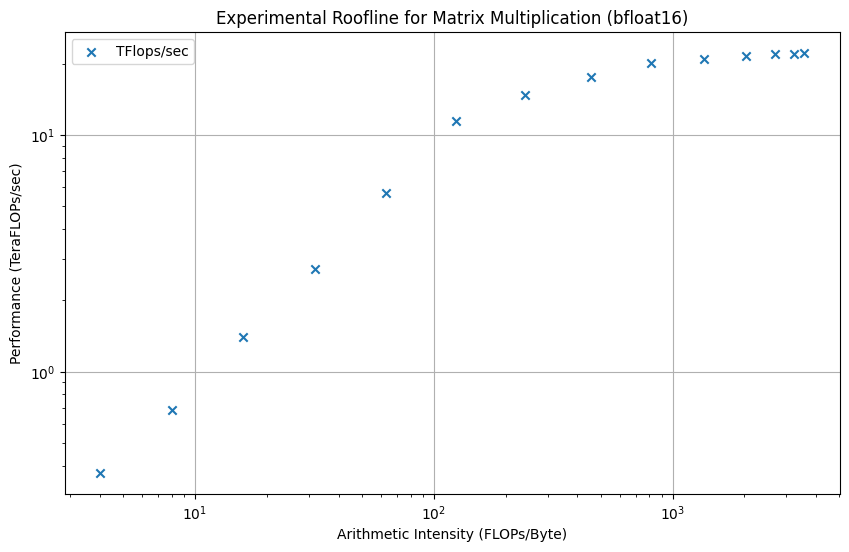

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(ais, tera_flops_per_sec, label='TFlops/sec', marker='x')
plt.xlabel('Arithmetic Intensity (FLOPs/Byte)')
plt.ylabel('Performance (TeraFLOPs/sec)')
plt.title('Experimental Roofline for Matrix Multiplication (bfloat16)')
plt.xscale('log') # Use log scale for Arithmetic Intensity for better visualization
plt.yscale('log') # Use log scale for Performance for better visualization
plt.grid(True)
plt.legend()
plt.show()

# plt.scatter(ais, tera_flops_per_sec)

## **Bonus: Investigating Compiler Optimizations (XLA)**##

JAX utilizes XLA (Accelerated Linear Algebra) for just-in-time compilation, which performs various optimizations under the hood. These optimizations can significantly impact performance and how operations map to the hardware. Some examples of XLA optimizations include:

Operator Fusion: Combining multiple operations into a single kernel to reduce memory traffic and improve data locality. For example,

```
A + B + C
```

might be fused into a single operation.

Operand Fusion (Fission): Optimizing data flow and memory access patterns, potentially breaking down or rearranging operations for better efficiency.




Example of Potential Compiler Optimizations:

Consider the difference between [A+B] and [A+B+C]. XLA might optimize A+B+C more effectively by fusing the additions, potentially leading to better performance than performing A+B and then adding C in separate steps, especially if these are jitted.

You could design experiments to investigate the impact of operator fusion. For example:

Time f_add_2(A, B) (jitted)

Define f_add_3(A, B, C) = A + B + C and time f_add_3(A, B, C) (jitted)

Compare the performance and see if f_add_3 shows better performance per operation due to fusion.

Note: The actual impact of compiler optimizations is complex and depends on many factors, including the specific hardware, operation characteristics, and XLA's optimization strategies. Experimentation and profiling are key to understanding these effects.

#### **Summary**

This notebook provides a basic introduction to roofline analysis and experimental performance evaluation using JAX. You can further extend these experiments by:

Exploring different datatypes (float32, float64, int).

Testing other operations (convolutions, reductions).

Running on different hardware backends (CPU, GPU, TPU) and comparing rooflines.

Using more advanced profiling tools to gain deeper insights into performance bottlenecks.


#### **References**
- [All About Rooflines](https://jax-ml.github.io/scaling-book/roofline/)